# Collaboration and Competition with MADDPG

---
In this project, we use the Unity ML-Agents environment to demonstrate how multi-agent deep deterministic policy gradient (MADDPG) can be used to solve collaboration and competition problems. This is the third project of the Deep Reinforcement Learning Nanodegree. Please follow the steps outlined in the README file to set up the necessary packages and environment.

In this implementation, we use the two agents in one single environment.


### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch

from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from maddpg import MADDPG, ReplayBuffer

import os
from utilities import transpose_list, transpose_to_tensor, convert_to_tensor
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name='env\Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 24 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. There has not been much information on the details of the 24 variables and how the two agent inputs are related to each other, making model construction difficult.

Run the code cell below to print some information about the environment.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]


# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the agents looks like:', states)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the agents looks like: [[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.65278625 -1.5
  -0.          0.          6.83172083  6.         -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.         -6.4669857  -1.5
   0.          0.         -6.83172083  6.          0.          0.        ]]


### 3. Multi-Agent Deep Deterministic Policy Gradient (MADDPG)

#### Key Concept:

In the previous Continuous Control with DDGP project, we successfully used DDPG to teach a double-jointed arm to move to target locations. The action space was continous and we had to use actor and critic design. However, in this environment, we have 2 agents playing against each other. In order to solve this, we are using a multi-agent version of DDPG in this project.


#### Actor and Critic

In DDPG, we use a seperate network to determine what the best action is for each state. This is the actor network. We use another network to model the expected value of a state + action combination. As mentioned in the DDPG paper, it is important to use targets for both actor and critic networks to help our models stablize.

#### Centralized Critic input

In this project, we will train two DDPG agents with their own actor and critic. However, the critics do not act in silo. Instead, each critic will take actions and states from both agents as input, so the critics have complete information from both sides of the table. This differentiates MADDPG from simple DDPG.


#### DDPG Agent
Having a relay buffer and seperating target and current networks are two key ideas that allow the model to learn. More specifically:

1. Replay Buffer:
Instead of using (state, action, reward) tuples in their natural order, our agent stores a bunch of such tuples in a relay buffer. In each iteration, at each time step, the agent will put the new (state, action, reward) tuple in to the buffer and pull out a random batch of tuples to update the networks

2. Target Q vs. Current Q:
At each step, instead of updating the current network according to values in the current network, we use a target network that only gets updated to the current network slowly. This prevents the networks from chasing after a moving target and helps the agent to learn better. We apply this concept to both actor and critic.  
  
For more details, see `networkforall.py` and `ddpg.py`  
  

#### MADDPG Agent
Each MADDPG agent has 2 DDPG agents. For each learning step, MADDPG agent obtains predicted actions and target actions from both agents and feed that information to the critics of both DDPG agents so that they can perform their individual updates.  
For more details, see `maddpg.py`  
  
#### More on Buffering
Buffering is very important for this project. Using only random actions, it's difficult to obtain a play session with more than 2 hits. In order to obtain a total score of 0.2, the ball must be hit at least 3 times which would result in a large number of observations of zero reward. Here, we fill the buffer up first with only play sessions that have hits. Furthermore, for sessions with more than 1 hit, we push the frames closer to the hit multiple times into the buffer. 
   


#### Learning Steps
Here are the major steps that happen during the learing step:
1. MADDPG agent takes in the buffered states, actions and next states
2. MADDOG agent obtains predicted actions and target actions from the up to date DDPG agents
3. Each DDPG agents feeds the combined states and actions to their critic network to obtain predicted and target Q value
4. Update the current critics using updated target Q values by minimizing the mse between the expected local Q and target Q
5. Obtain the predicted action using current actor network for each DDPG agent
6. Update the current actors by following the action-value gradient
7. Soft update the target networks with a small fraction of the current networks

There are more than one way to solve this problem, there are many other ways the MADDPG can be structured.

### 4. Train MADDPG!

To deploy our agent to solve the navigation problem, we first import the agent class we wrote. When training the environment, set train_mode=True, so that the line for resetting the environment looks like the following:

```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### Set parameters

In [5]:
# setting parameters

# number of training episodes.
NUMBER_OF_EPISODES = 10000
EPISODE_LENGTH = 1000
BATCHSIZE =200

UPDATE_EVERY = 2
# how many periods before update
NOISE = 1
NO_NOISE_AFTER = 3000
NOISE_DECAY = 0.9999
# amplitude of OU noise
# this slowly decreases to 0
# instead of resetting noise to 0 every episode, we let it decrease to 0 over a few episodes

MIN_BUFFER_SIZE = 60000
BUFFER_SIZE = 500000
# fill the buffer before training to MIN_BUFFER_SIZE

IN_ACTOR_DIM = 24 
HIDDEN_ACTOR_IN_DIM = 400
HIDDEN_ACTOR_OUT_DIM = 400
OUT_ACTOR_DIM = 2
# Critic input contains both states AND all the actions of all the agents
IN_CRIT_S = IN_ACTOR_DIM  * num_agents 
IN_CRIT_A = action_size * num_agents
HIDDEN_CRIT_IN_DIM = 400
HIDDEN_CRIT_OUT_DIM = 400
OUT_CRIT_DIM = 1

SEED = 0
DISC = 0.99
TAU = 0.001
LR_ACT = 0.0001
LR_CRI = 0.001
# The learning rate will be decreased during learning

In [6]:
# Initialization
np.random.seed(SEED)
torch.manual_seed(SEED)
t = 0

# initialize policy and critic through MADDOG
maddpg = MADDPG(IN_ACTOR_DIM, HIDDEN_ACTOR_IN_DIM, HIDDEN_ACTOR_OUT_DIM, OUT_ACTOR_DIM,\
                IN_CRIT_S, IN_CRIT_A, HIDDEN_CRIT_IN_DIM, HIDDEN_CRIT_OUT_DIM, SEED, LR_ACT, LR_CRI, DISC, TAU)

# these will be used to print rewards for agents
agent0_reward = []
agent1_reward = []
scores_deque = deque(maxlen=100)
best_scores = []
avg_best_score = []
update_t = 0
log_path = os.getcwd()+"/log"
model_dir= os.getcwd()+"/model_dir"

os.makedirs(model_dir, exist_ok=True)

In [7]:
def process_data (states, actions, rewards, next_states, dones):
    full_state = states.flatten()
    next_full_state = next_states.flatten()
    return (states, full_state, actions, rewards, next_states, next_full_state, dones)

def fill_buffer(buffer):
    while len(buffer) <= MIN_BUFFER_SIZE:
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = [0,0] 
        all_t_episode = []
        
        for t in range(1000): 
            state_tensors = convert_to_tensor(states)
            actions = maddpg.act(state_tensors, noise = NOISE)
            actions_array = torch.stack(actions).detach().numpy()

            env_info = env.step(actions_array)[brain_name] 
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones  = env_info.local_done   

            transition = process_data(states, actions_array, rewards, next_states, dones)
            
            all_t_episode.append(transition)

            scores = [sum(x) for x in zip(scores, rewards)]
            states = next_states  
            if dones[0] and max(scores) < 0.05:
                break
            elif dones[0] and max(scores) > 0.05:
                how_many_times = 1 if sum(scores) < 0.11 else int(sum(scores)/ 0.08) ** int(sum(scores)/ 0.08) *10
                
                # push successful hit multiple times 
                for t, transition in enumerate(all_t_episode):
                    buffer.push(transition) 
                    if t+3 > len(all_t_episode):
                        continue
                    elif max(transition[3]) > 0.05 or max(all_t_episode[t+1][3]) > 0.05  or max(all_t_episode[t+2][3]) > 0.05:
                        for j in range(min(how_many_times, 500)):
                            buffer.push(transition)                 
                                                        
                break
            else:
                continue

    print("finished pushing to buffer, total length now:", len(buffer)) 

In [8]:
buffer = ReplayBuffer(int(BUFFER_SIZE))
fill_buffer(buffer)

finished pushing to buffer, total length now: 60032


### Main training block

In [9]:

for episode in range(1, NUMBER_OF_EPISODES+1):

    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations

    scores = [0,0]   
    all_t_episode =[]
    
    if episode > NO_NOISE_AFTER:
        NOISE *= NOISE_DECAY

    for episode_t in range(EPISODE_LENGTH):

        state_tensors = convert_to_tensor(states)
        actions = maddpg.act(state_tensors, noise = NOISE)
        actions_array = torch.stack(actions).detach().numpy()

        env_info = env.step(actions_array)[brain_name] 
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones  = env_info.local_done

        transition = process_data(states, actions_array, rewards, next_states, dones)
        all_t_episode.append(transition)
                
        scores = [sum(x) for x in zip(scores, rewards)]
        states = next_states    
        update_t = (update_t + 1) % UPDATE_EVERY
        
        if len(buffer) > MIN_BUFFER_SIZE and update_t == 0:
            samplesa = buffer.sample(BATCHSIZE)
            samplesb = buffer.sample(BATCHSIZE)
            maddpg.update(samplesa, samplesb)

        if dones[0]:
            if max(scores) > 0.05 :
                how_many_times = 1 if (sum(scores) < 0.11 or len(buffer) == 500000) else int(sum(scores)/ 0.08) ** int(sum(scores)/ 0.08) 
                for transition in all_t_episode:                                    
                    buffer.push(transition) 
                    if t+3 > len(all_t_episode):
                        continue
                    elif max(transition[3]) > 0.05 or max(all_t_episode[t+1][3]) > 0.05  or max(all_t_episode[t+2][3]) > 0.05:
                        for j in range(min(how_many_times, 200)):
                            buffer.push(transition)                       

            break                      
                    
    agent0_reward.append(scores[0])
    agent1_reward.append(scores[1])

    best_scores.append(max(scores))
    scores_deque.append(max(scores))    
    avg_best_score.append(np.mean(scores_deque))
    
    
    if np.mean(scores_deque) >= 0.47:
        LR_ACT = 0.00005
        LR_CRI = 0.0001       
    elif np.mean(scores_deque) >= 0.45:
        LR_ACT = 0.00008
        LR_CRI = 0.0005    


    # print score every 100 episodes and save model 
    if episode % 100 == 0 or episode == NUMBER_OF_EPISODES-1 or  np.mean(scores_deque)>=0.5:
        print('\rEpisode {}\tBuffer Len {}\tAverage Last 100 Episodes Score: {:.2f}'.format(episode, len(buffer),np.mean(scores_deque)))
            
        for i in range(num_agents):   
            save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor.state_dict(),
                         'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                         'critic_params' : maddpg.maddpg_agent[i].critic.state_dict(),
                         'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}            

            torch.save(save_dict, os.path.join(model_dir, 'checkpoint.pth'))

    # problem solved
    if  np.mean(scores_deque)>=0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Last 100 Episodes Score: {:.2f}'.format(episode, np.mean(scores_deque)))            
        break     



Episode 100	Buffer Len 60068	Average Last 100 Episodes Score: 0.00
Episode 200	Buffer Len 60098	Average Last 100 Episodes Score: 0.00
Episode 300	Buffer Len 60098	Average Last 100 Episodes Score: 0.00
Episode 400	Buffer Len 60098	Average Last 100 Episodes Score: 0.00
Episode 500	Buffer Len 60098	Average Last 100 Episodes Score: 0.00
Episode 600	Buffer Len 60098	Average Last 100 Episodes Score: 0.00
Episode 700	Buffer Len 60098	Average Last 100 Episodes Score: 0.00
Episode 800	Buffer Len 60098	Average Last 100 Episodes Score: 0.00
Episode 900	Buffer Len 60098	Average Last 100 Episodes Score: 0.00
Episode 1000	Buffer Len 60098	Average Last 100 Episodes Score: 0.00
Episode 1100	Buffer Len 60098	Average Last 100 Episodes Score: 0.00
Episode 1200	Buffer Len 60098	Average Last 100 Episodes Score: 0.00
Episode 1300	Buffer Len 60098	Average Last 100 Episodes Score: 0.00
Episode 1400	Buffer Len 60098	Average Last 100 Episodes Score: 0.00
Episode 1500	Buffer Len 60098	Average Last 100 Episodes S

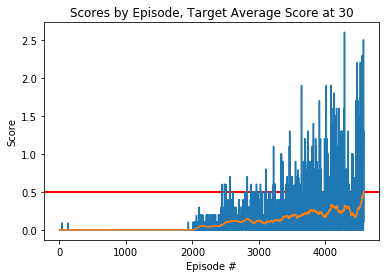

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.axhline(y = 0.5, linewidth=2, color='r')
plt.plot(np.arange(1, len(best_scores)+1), best_scores)
plt.plot(np.arange(1, len(avg_best_score)+1), avg_best_score)
plt.title('Scores by Episode, Target Average Score at 30')

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Observe trained agent

After successfully training agent and storing the weights, we can see it in action by running the following cell. The learned agents are able to play with each other quite well!

In [11]:

for i in range(10):                                         # play game for 10 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        state_tensors = convert_to_tensor(states)
        
        actions = maddpg.act(state_tensors, noise = 0)
        actions_array = torch.stack(actions).detach().numpy()
        env_info = env.step(actions_array)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.44500000681728125
Total score (averaged over agents) this episode: 0.29500000458210707
Total score (averaged over agents) this episode: 2.095000031404197
Total score (averaged over agents) this episode: 2.550000037997961
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 2.600000038743019
Total score (averaged over agents) this episode: 0.8450000127777457
Total score (averaged over agents) this episode: 0.7450000112876296
Total score (averaged over agents) this episode: 1.7950000269338489


### 6. Future Improvements

There are a few ways this solution could be improved. 
  
1. Better understanding of inputs and agents:  
Currently the two DDPG agents were treated independently. However, they should be the same because their goal is the same. Better understanding how to transform one agent's learning and observations to be used for the opponent agent, training can be done much faster. In that case, simple DDPG would work because with proper transformation, the two agents can be viewed as playing from the same side and hence be trained using the same agent.    
    
2. The Deep Neural Nets have not been optimized. We did not experiement with a wide range of hype-parameters to pick and choose the best assumptions that optimize this problem.      
    
3. Better buffering:   
Playing table tennis is difficult, especially with untrained agents. Having good experience in the buffer for training is crucial. We could explore other ways to better incorporate experience in the buffer for better training  
    
4. Parallel environment:   
We could explore training in parallel environment to make training faster    
     
5. Others: There are other methods that can be used to solve this problem. For example, Trust Region Policy Optimization (TRPO) seems to produce great results for many reinforcement tasks.   
  